In [357]:
import sys
sys.path.insert(1, '../evaluator')

import gc
import itertools
import random as rndm
import numpy as np
import matplotlib.pyplot as plt
from skimage import draw
from evaluator import *
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

%matplotlib inline

In [358]:
'''
evaluator.py
IMPORTS:

getTurbLoc(TURB_LOC_file_name)

loadPowerCurve(POWER_CURVE_file_name)

binWindResourceData(WIND_DATA_file_name)

searchSorted(lookup, sample_array)

preProcessing(POWER_CURVE)

getAEP(TURB_DIAM, turb_coords, POWER_CURVE, WIND_INST_FREQ,
       N_WIND_INSTANCES, COS_DIR, SIN_DIR, WIND_SPEED_STACKED, C_t)
       
checkConstraints(turb_coords, TURB_DIAM)

'''

# Turbine Specifications.
# -**-SHOULD NOT BE MODIFIED-**-
TURB_SPECS    =  {
                     'Name': 'Anon Name',
                     'Vendor': 'Anon Vendor',
                     'Type': 'Anon Type',
                     'Dia (m)': 100,
                     'Rotor Area (m2)': 7853,
                     'Hub Height (m)': 100,
                     'Cut-in Wind Speed (m/s)': 3.5,
                     'Cut-out Wind Speed (m/s)': 25,
                     'Rated Wind Speed (m/s)': 15,
                     'Rated Power (MW)': 3
                 }
TURB_DIAM      =  TURB_SPECS['Dia (m)']
TURB_DIAM       =  TURB_DIAM/2

# Load the power curve
POWER_CURVE   =  loadPowerCurve('./../evaluator/power_curve.csv')

# Pass wind data csv file location to function binWindResourceData.
# Retrieve probabilities of wind instance occurence.
WIND_INST_FREQ =  binWindResourceData('./../evaluator/wind_data/wind_data_2007.csv')

# Doing preprocessing to avoid the same repeating calculations. Record
# the required data for calculations. Do that once. Data are set up (shaped)
# to assist vectorization. Used later in function totalAEP.
N_WIND_INSTANCES, COS_DIR, SIN_DIR, WIND_SPEED_STACKED, C_t = preProcessing(POWER_CURVE)

# check if there is any constraint is violated before we do anything. 
def evalPrint(turbine_coordinates):
    checkConstraints(turbine_coordinates, TURB_DIAM)
    
    print('[INFO] Calculating AEP')
    AEP = getAEP(TURB_DIAM, turbine_coordinates, POWER_CURVE, WIND_INST_FREQ,
                 N_WIND_INSTANCES, COS_DIR, SIN_DIR, WIND_SPEED_STACKED, C_t)
    print('[INFO] Power produced : ', "%.12f"%(AEP), 'GWh')
    
    
def create_submission_df(coordinates):
    df = pd.DataFrame(coordinates, columns =['x', 'y'])
    df.to_csv('submission.csv', index=False)
    
# TEST VALUES
# Turbine x,y coordinates
TEST_COORDS   =  getTurbLoc(r'./../test_locations.csv')

In [359]:
%%time
# SELF TEST
_ = checkConstraints(TEST_COORDS, TURB_DIAM)
print("--------######---------")
evalPrint(TEST_COORDS)
print()

[SUCCESS] perimeter and proximity constraints - SATISFIED
--------######---------
[SUCCESS] perimeter and proximity constraints - SATISFIED
[INFO] Calculating AEP
[INFO] Power produced :  505.450636596680 GWh

CPU times: user 145 ms, sys: 13 ms, total: 158 ms
Wall time: 166 ms


## Classes

In [360]:
class DNA:
    ###########################################
    def __init__(self):
        self.fitness = 0
        self.genes, self.state = self.generate_init_state()
       

    ###########################################
    # GENERATE SET OF VALID GENES
    def generate_init_state(self):
        state = np.zeros((3900, 3900)).astype(np.int8)
        coordinates = np.array([], dtype=np.int64).reshape(0,2)

        count_placed = 0
        while(count_placed < 50):
            free_coordinates = np.where(state == 0)
            if(len(free_coordinates[0]) == 0): 
                return -1

            free_coordinates = np.stack([*free_coordinates]).transpose()
            chosen_coordinate = rndm.choice(free_coordinates)
            
            r, c = draw.circle(chosen_coordinate[0], chosen_coordinate[1], radius=400, shape=state.shape)
            state[r, c] = 1
            r, c = draw.circle(chosen_coordinate[0], chosen_coordinate[1], radius=50, shape=state.shape)
            state[r, c] = 2

            coordinates = np.concatenate([coordinates, chosen_coordinate.reshape(1,2)], axis=0)
            count_placed += 1

        coordinates = coordinates + 50
        coordinates = coordinates[np.lexsort((coordinates[:,1],coordinates[:,0]))]
        
        return (coordinates.flatten(),  np.pad(state, 50))

    # UPDATE CURRENT STATE
    def update_current_state(self):
        coordinates = self.get_tuples()
        state = np.zeros((4000, 4000)).astype(np.int8)
        for coord in coordinates:
            r, c = draw.circle(coord[0], coord[1], radius=400, shape=state.shape)
            state[r, c] = 1
            r, c = draw.circle(coord[0], coord[1], radius=50, shape=state.shape)
            state[r, c] = 2
        self.state = state
        
    
    ###########################################
    # CALC & STORE FITNESS
    def calc_fitness(self):
        if(checkConstraints_F(self.get_tuples(), TURB_DIAM) == -1):
            return 450
        self.fitness = getAEP(TURB_DIAM, self.get_tuples(), POWER_CURVE, WIND_INST_FREQ, 
                              N_WIND_INSTANCES,COS_DIR, SIN_DIR, WIND_SPEED_STACKED, C_t)
        return self.fitness
    
    
    ###########################################
    # GET DNA AS TUPLE OF COORDINATES (IF FLATTENED)
    def get_tuples(self):
        return np.reshape(self.genes, newshape=(50,2))
    
    def __getitem__(self, index):
        print("[ERR] USE d.genes[i]")

In [363]:
class Population:
    ###########################################
    def __init__(self, population_size, mutation_rate):
        self.best_DNA = None
        self.max_fitness = 0
        self.gen_min_fitness = 0
        self.population_fitnesses = None
        self.generations = 0
        
        self.population_size = population_size
        self.mutation_rate = mutation_rate

        # Multithreaded population init
        processes = []
        with ProcessPoolExecutor(max_workers=4) as executor:
            for _ in range(self.population_size): 
                processes.append(executor.submit(DNA))
        self.population = np.array([processes[i].result() for i in range(self.population_size)])
        self.next_population = None
    
    
    ###########################################
    # CALC & GET FITNESS   
    def calc_fitnesses(self):
        fitnesses = np.array([self.population[i].calc_fitness() for i in range(self.population_size)])
        self.gen_min_fitness = np.min(fitnesses)
        max_index = np.argmax(fitnesses)
        if(fitnesses[max_index] > self.max_fitness):
            self.best_DNA = self.population[max_index]
            self.max_fitness = fitnesses[max_index]
        self.population_fitnesses = fitnesses
        return fitnesses
        
    def get_fitnesses(self):
        return np.array([self.population[i].fitness for i in range(self.population_size)])
    
    
    #############################################
    # NATURAL SELECTION   
    def create_crossover(self):
        weights = (self.population_fitnesses - self.gen_min_fitness) / (self.max_fitness - self.gen_min_fitness)
        new_population = self.population
        for i in range(50):
            parents = rndm.choices(self.population, weights=weights, k=2)
            # Do crossover mixup
            # modify i'th DNA in new_poplation[i].genes
            # Try parallelisation
        # set self.new_population = new_population
        return weights
        
    def create_mutation(self):
        #mutate self.new_population with mutation_rate
        pass
            
    #############################################
    # GET DNAs            
    def get_population_coordinates(self):
        return np.array([self.population[i].get_tuples() for i in range(self.population_size)])
        
    def __getitem__(self, index):
        return self.population[index]

# Main

In [364]:
%%time
# 1
# MULTITHREAD
x = Population(2, 0.1)

CPU times: user 42.2 ms, sys: 77.8 ms, total: 120 ms
Wall time: 13.4 s


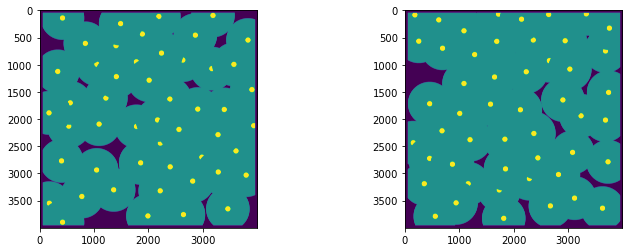

In [365]:
# 1
_, ax = plt.subplots(ncols=2, figsize=(12,4))
for i in range(2):
    ax[i].imshow(x.population[i].state)

In [366]:
display(x.population[0].genes)
# display(x.population[0].get_tuples())
display(x.population[0].genes.shape)

array([  99, 3174,  118, 2181,  146,  413,  249, 1479,  440, 1877,  461,
       2850,  551, 3816,  612,  831,  654, 1395,  790, 2229,  918, 2621,
        950, 1768,  995, 1045,  997, 3558, 1075, 3154, 1127,  326, 1222,
       1400, 1288, 2002, 1460, 3888, 1615, 1209, 1634, 2383, 1703,  554,
       1818, 2895, 1825, 3380, 1887,  165, 2017, 2157, 2093, 1084, 2122,
       3922, 2130,  528, 2136, 1770, 2191, 2550, 2287, 3266, 2442, 2207,
       2585, 3596, 2700, 2970, 2768,  395, 2804, 1847, 2877, 2388, 2935,
       1039, 2972, 3270, 3029, 3782, 3139, 2802, 3299, 1352, 3317, 2205,
       3421,  768, 3545,  171, 3648, 3447, 3753, 2632, 3778, 1980, 3893,
        414])

(100,)

In [367]:
%%time
x.calc_fitnesses()

CPU times: user 167 ms, sys: 24.6 ms, total: 192 ms
Wall time: 201 ms


array([508.07649124, 511.58057144])

In [368]:
x.create_crossover()

array([0., 1.])